# Fraud Detection Algorithm

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import seaborn as sns


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Read-In and Pre-Processing

In [2]:
# Read in Data
df1 = pd.read_csv('train_transaction.csv',low_memory=False)
df2 = pd.read_csv('train_identity.csv',low_memory=False)
dft1 = pd.read_csv('test_transaction.csv',low_memory=False)
dft2 = pd.read_csv('test_identity.csv',low_memory=False)

In [3]:
print("Shape of df1:", df1.shape)
print("Shape of df2:", df2.shape)
print("Shape of dft1:", dft1.shape)
print("Shape of dft2:", dft2.shape)

Shape of df1: (590540, 394)
Shape of df2: (144233, 41)
Shape of dft1: (506691, 393)
Shape of dft2: (141907, 41)


In [4]:
# Compare lists, are there identical elements?

# get List of Values
Val_d1 =list(df1)
Val_d2 = list(df2)
print("Identical Columns: ", set(Val_d1) & set(Val_d2))

Identical Columns:  {'TransactionID'}


In [5]:
print("df-ID is in df2: ", df1['TransactionID'].isin(df2['TransactionID']).value_counts())
print("df2-ID is in df1", df2['TransactionID'].isin(df1['TransactionID']).value_counts())

df-ID is in df2:  False    446307
True     144233
Name: TransactionID, dtype: int64
df2-ID is in df1 True    144233
Name: TransactionID, dtype: int64


In [6]:
# Merge with TransactionID
# df is main dataset which contains label:
# We need an left outer join: All df and the matches with df2
#Merge Data
dfsum = pd.merge(df1, df2, on = 'TransactionID', how='left')
dftsum = pd.merge(dft1, dft2, on = 'TransactionID', how='left')
Trainlength = len(dfsum)
print("Shape of Train Data:", dfsum.shape)
print("Shape of Test Data:", dftsum.shape)

Shape of Train Data: (590540, 434)
Shape of Test Data: (506691, 433)


In [7]:
# Delete obsolete dataframes
del df1
del df2
del dft1
del dft2

## Data Engineering
 - Seperate Numbers and Objects
 - Drop all Numbers w/ low correlations
 - Label Encoding for Objects
 - Fill NA Values with median
 - Scaling

In [8]:
# Share of fraud
print("Share of fraud: ", dfsum["isFraud"].sum()/len(dfsum))

Share of fraud:  0.03499000914417313


(0, 7000)

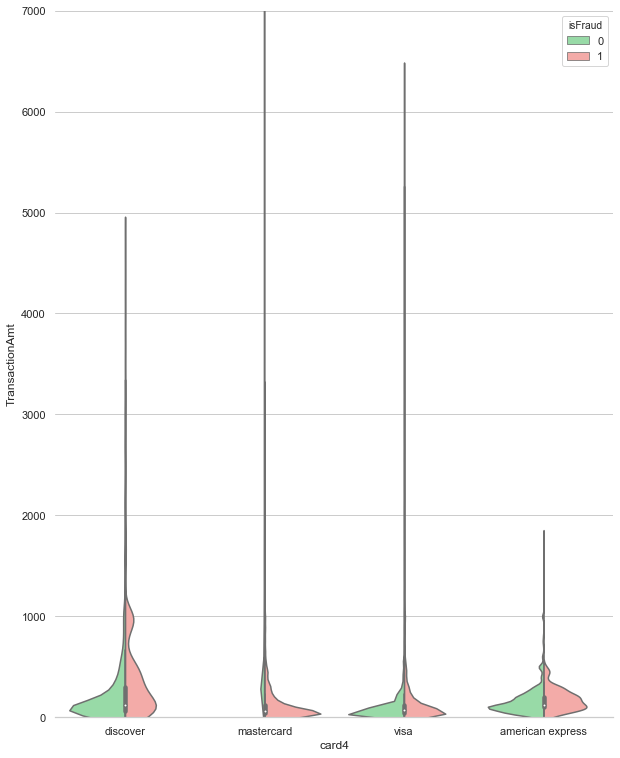

In [9]:
# Plotting Violinplot: Compare fraud and non-fraud Transactions with regard to used credit card and transaction amount

sns.set(style="whitegrid", palette="pastel", color_codes=True, rc={'figure.figsize':(10,13)})
sns.violinplot(x="card4", y = "TransactionAmt", hue="isFraud", split=True, 
               palette={1: "r", 0: "g"},  data =dfsum)
sns.despine(left=True)
plt.ylim(0,7000)

Objects: 31
Numbers: 403
all 434


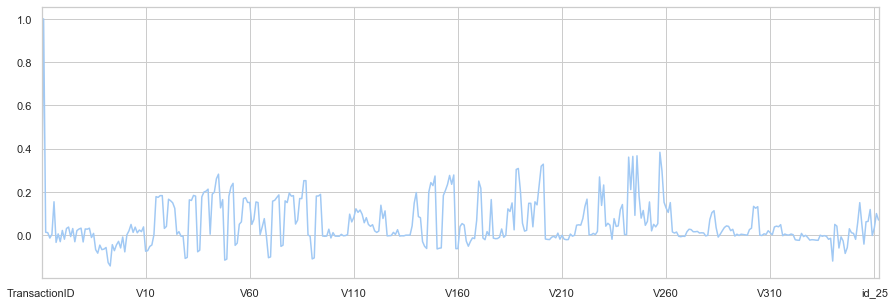

In [10]:
# Select between Numbers and Categories
dfobj = dfsum.select_dtypes(include=['object'])
dftobj = dftsum.select_dtypes(include=['object'])

print("Objects:", len(dfobj.columns))

dfnums = dfsum.select_dtypes(include=['int64','float64'])
dftnums = dftsum.select_dtypes(include=['int64','float64'])
print("Numbers:", len(dfnums.columns))
print("all", len(dfsum.columns))

# Show Correlations of numbers - Values
dffraud = dfsum['isFraud']
#dffraud.head()
corr = dfnums.corrwith(dffraud)
mpl.rc('figure', figsize=(15, 5))
corr.plot()


In [11]:
# Data Engineering Numbers
print(dfnums.shape)
print(dfobj.shape)
print(dftobj.shape)

# Dropp all with correlations > and < 0.15
corr_sel = corr[abs(corr)<0.015]
print("Columns with low correlation: ", len(corr_sel))

dfnum_red = dfnums.drop(corr_sel.index, axis = 1)
dftnum_red = dftnums.drop(corr_sel.index, axis = 1)

# Check which colums have > 90% NaN
nanlist = dfnum_red.columns[(dfnum_red.isnull().sum()/len(dfsum)>0.9)]
#print(nanlist)

#Remove Columns with >90% Nan
dfnum_red = dfnums.drop(nanlist, axis = 1)
dftnum_red = dftnums.drop(nanlist, axis = 1)

print(len(dfnum_red.columns))

(590540, 403)
(590540, 31)
(506691, 31)
Columns with low correlation:  113
394


In [12]:
# For Label encoding and Fill nan: Append train and test data
dfobj = dfobj.append(dftobj)
dfnum_red = dfnum_red.append(dftnum_red)

C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [13]:
# Data Engineering Objects
print("Objects:", len(dfobj.columns))
for col in dfobj.columns:
    lbe = preprocessing.LabelEncoder()
    lbe.fit(list(dfobj[col].values))
    dfobj[col] = lbe.transform(list(dfobj[col].values))

Objects: 31


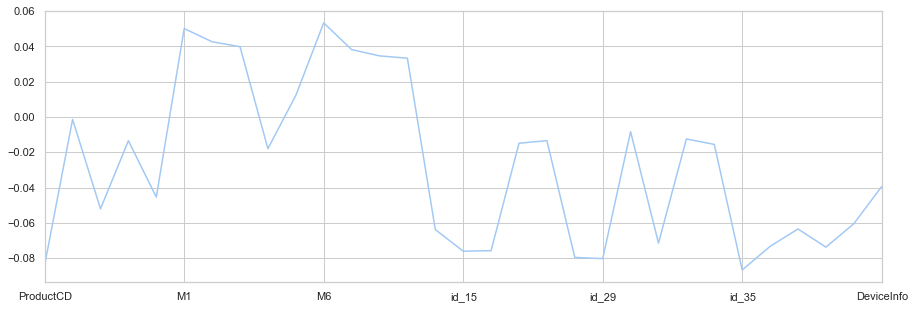

In [14]:
corr = dfobj.corrwith(dffraud)
mpl.rc('figure', figsize=(15, 5))
corr.plot()

In [15]:
#Fill NA with median (not mean because of outliers)
dfnum_red.fillna(dfnum_red.median(),inplace=True)

In [16]:
# Concat numbers and Objects to generate train data

dfX = pd.concat([dfnum_red, dfobj], axis =1)


# Create Dataframe with Traindata
dfX_train = dfX.head(Trainlength)


# Scaling, create array

# X = Feature matrix without label
X = dfX.drop(columns=['isFraud'])

#y = label
y = (dfX_train['isFraud'])

# Scaling
X = preprocessing.scale(X)

# Split in Train and Test (unlabelled)
Xtrain=X[:Trainlength,:]
Xtest=X[Trainlength:,:]

# Delete obsolte dataframes
del dftobj
del dftnums
del dfnum_red
del dfobj
del dfX
del dfX_train

## Logisitic Regression

In [17]:
# Seperate Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.2)

In [18]:
# Logistic Regression with different C-Values 
# You can try many values, eg. [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15,20,25,50,100,500,1000,5000,10000,50000,100000]:
for cval in [0.01, 1]:
    logreg = linear_model.LogisticRegression(C=cval) 
    logreg.fit(X_train, y_train)
    print('Score for C = ',cval, " is: " , logreg.score(X_test, y_test))
    y_pred =logreg.predict(X_test)
    print('Classification Report for C = ', cval)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score for C =  0.01  is:  0.971813933010465
Classification Report for C =  0.01
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    113976
         1.0       0.83      0.24      0.38      4132

    accuracy                           0.97    118108
   macro avg       0.90      0.62      0.68    118108
weighted avg       0.97      0.97      0.96    118108

[[113771    205]
 [  3124   1008]]


C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score for C =  1  is:  0.9719663358959596
Classification Report for C =  1
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    113976
         1.0       0.82      0.26      0.39      4132

    accuracy                           0.97    118108
   macro avg       0.89      0.63      0.69    118108
weighted avg       0.97      0.97      0.96    118108

[[113737    239]
 [  3072   1060]]


## Prediction

In [19]:
# Prediction of unlabelled data
ytest =logreg.predict(Xtest)
print("Share of Fraud: ", y_test.sum()/len(y_test))

Share of Fraud:  0.03498492904798998


In [21]:
print(len(X_test))
for tresh in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred2 = np.where(logreg.predict_proba(X_test)[:,1] > tresh, 1, 0)
    print("Confusion Matrix for Treshold:", tresh, confusion_matrix(y_test, y_pred2))

118108
Confusion Matrix for Treshold: 0.2 [[112699   1277]
 [  2583   1549]]
Confusion Matrix for Treshold: 0.3 [[113317    659]
 [  2793   1339]]
Confusion Matrix for Treshold: 0.4 [[113598    378]
 [  2934   1198]]
Confusion Matrix for Treshold: 0.5 [[113737    239]
 [  3072   1060]]
Confusion Matrix for Treshold: 0.6 [[113824    152]
 [  3174    958]]
Confusion Matrix for Treshold: 0.7 [[113883     93]
 [  3266    866]]
